In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [7]:
path = Config().data_path()/'mnist'

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [9]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

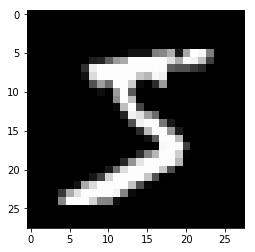

In [10]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [11]:
type(x_train)

numpy.ndarray

In [12]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid)) # create torch sensor from nparray
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [13]:
type(x_train)

torch.Tensor

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [14]:
bs=64
train_ds = TensorDataset(x_train, y_train) # create data sets in tensors
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) # create databunch from data sets; make sure training set is 
#shuffled and data is put on the GPU, etc; mainly prepping for training;

In [15]:
type(train_ds)

torch.utils.data.dataset.TensorDataset

In [16]:
type(data)

fastai.basic_data.DataBunch

In [17]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [18]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__() # when creating your own archtecture; DO not forget this one!
        self.lin = nn.Linear(784, 10, bias=True) # this does (x@a + b)

    def forward(self, xb): return self.lin(xb) ## this does (xb@a + b); where xb is a minibatch
    # this is a logistic regression, aka, nn with no hidden layers. 

In [19]:
model = Mnist_Logistic().cuda()   
# shift + tab
# Moves all model parameters and buffers to the GPU.

# This also makes associated parameters and buffers different objects. So
# it should be called before constructing optimizer if the module will
# live on GPU while being optimized.

In [20]:
model # nn.module gives representation of model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [21]:
model.lin 

Linear(in_features=784, out_features=10, bias=True)

In [22]:
model(x).shape

torch.Size([64, 10])

In [23]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [26]:
h= next(model.parameters())

In [25]:
h.shape

torch.Size([10, 784])

In [27]:
h.shape

torch.Size([10, 784])

In [28]:
lr=2e-2

In [29]:
loss_func = nn.CrossEntropyLoss()

In [30]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)# call model as if it's a function
    # weight decay
    w2 = 0. #init regularization term
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [31]:
losses = [update(x,y,lr) for x,y in data.train_dl]

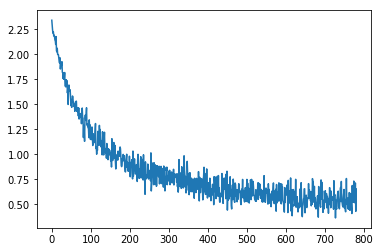

In [32]:
plt.plot(losses);

In [33]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [34]:
model = Mnist_NN().cuda()

In [35]:
losses = [update(x,y,lr) for x,y in data.train_dl]

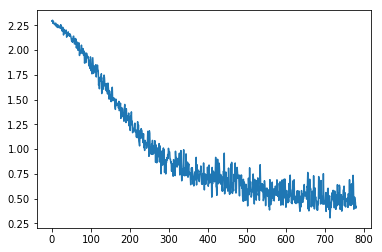

In [36]:
plt.plot(losses);

In [37]:
model = Mnist_NN().cuda()

In [38]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [39]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

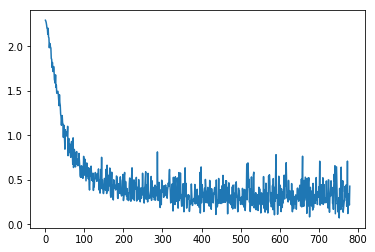

In [40]:
plt.plot(losses);

In [41]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [43]:
Learner??

In [ ]:
%debug

> /home/ubuntu/fastai/fastai/basic_data.py(20)DataLoader___getattr__()
     18 torch.utils.data.DataLoader.__init__ = intercept_args
     19 
---> 20 def DataLoader___getattr__(dl, k:str)->Any: return getattr(dl.dataset, k)
     21 DataLoader.__getattr__ = DataLoader___getattr__
     22 

ipdb> u
> /home/ubuntu/fastai/fastai/basic_data.py(38)__getattr__()
     36 
     37     def __len__(self)->int: return len(self.dl)
---> 38     def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
     39     def __setstate__(self,data:Any): self.__dict__.update(data)
     40 

ipdb> print(k)
loss_func
ipdb> q


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


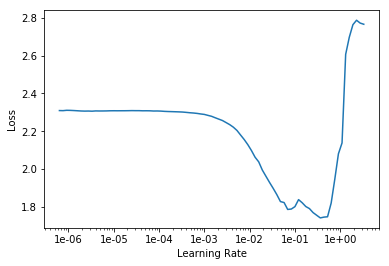

In [42]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.143669,0.133948,0.961500,00:05


In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.129131,0.125927,0.963500


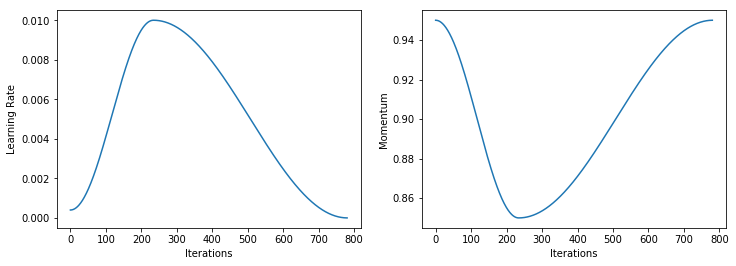

In [45]:
learn.recorder.plot_lr(show_moms=True)

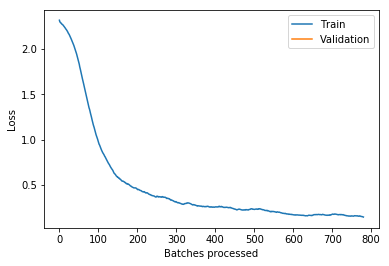

In [46]:
learn.recorder.plot_losses()

## fin